# Linear Regression
In the file ``Propeller_identification.ipynb`` we tested the motor and collected the data points, which are stored in ``.csv`` files.

Now we use the dataset to determine the coefficients of the transfer function of the motor.

In [55]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## PWM to Thrust transfer function
We assume the function to be linear

### Ramp

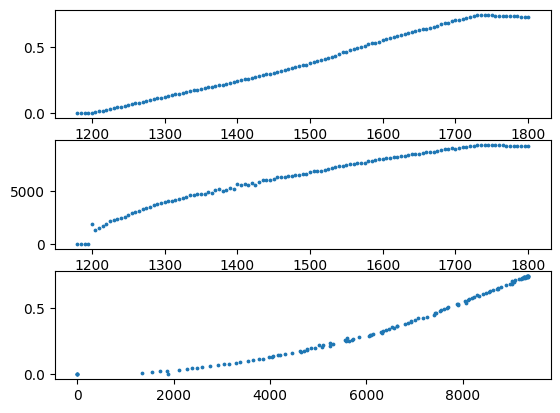

In [56]:
# Load the data
filename = 'Dataset_ramp copy.csv'
data = pd.read_csv(filename, sep=',')
data.describe()

# Split the columns
pwm = data['PWM'].to_numpy().reshape(-1,1)
rpm = data['RPM'].to_numpy().reshape(-1,1)
thrust = data['Thrust'].to_numpy().reshape(-1,1)
#print(pwm.head())
#print(rpm.head())
#print(thrust.head())

fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.scatter(pwm, thrust, s=3)
ax2.scatter(pwm, rpm, s=3)
ax3.scatter(rpm, thrust, s=3)

If the motor saturated, remove the saturated samples

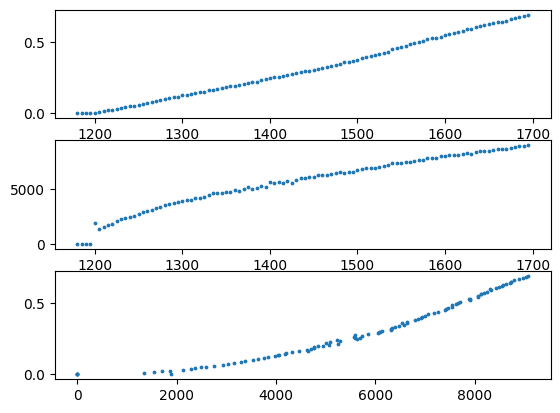

In [57]:
# Remove samples above the upper limit
upper_limit = 1700
data = data[ data['PWM'] < upper_limit ]

# Split the columns
pwm = data['PWM'].to_numpy().reshape(-1,1)
rpm = data['RPM'].to_numpy().reshape(-1,1)
thrust = data['Thrust'].to_numpy().reshape(-1,1)

# Check the plots
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.scatter(pwm, thrust, s=3)
ax2.scatter(pwm, rpm, s=3)
ax3.scatter(rpm, thrust, s=3)

[[0.00138785]]
predicted_thrust: (104, 1)


Text(0, 0.5, 'Thrust')

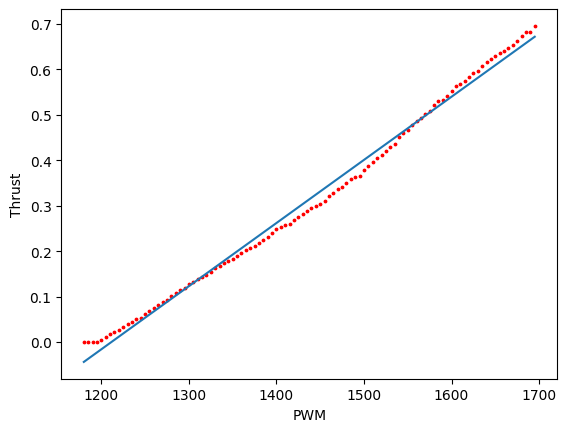

In [58]:
# Define the linear regression model
from sklearn import linear_model
linreg = linear_model.LinearRegression()

# Train the model on the dataset
linreg.fit(pwm, thrust)
w = linreg.coef_.reshape(-1,1)
print(w)

# Predict the values
predicted_thrust = linreg.predict(pwm)
print(f"predicted_thrust: {predicted_thrust.shape}")

# Plot
fig, axes = plt.subplots()
axes.scatter(pwm, thrust, s=3, color='red')
axes.plot(pwm, predicted_thrust)
plt.xlabel('PWM')
plt.ylabel('Thrust')

[[-5.00768327e-06]
 [ 9.03539205e-09]]
predicted_thrust: (104, 1)


Text(0, 0.5, 'Thrust')

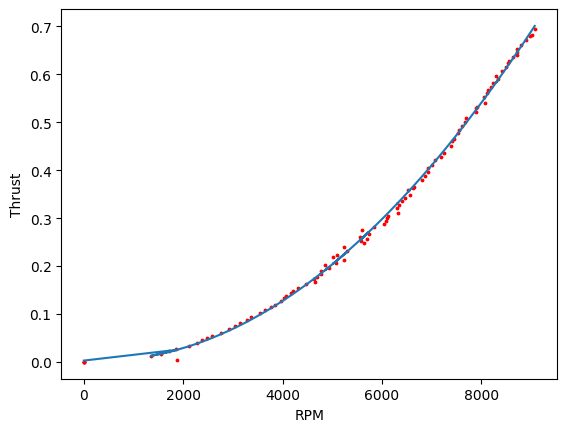

In [59]:
# Define the basic function for the rpm to thrust function
phi = np.power(rpm, [1,2])
#print(phi)
assert phi.shape == (rpm.shape[0], 2)

# Train the model on the dataset
linreg.fit(phi, thrust)
w = linreg.coef_.reshape(-1,1)
print(w)

# Predict the values
predicted_thrust = linreg.predict(phi)
print(f"predicted_thrust: {predicted_thrust.shape}")

# Plot
fig, axes = plt.subplots()
axes.scatter(rpm, thrust, s=3, color='red')
axes.plot(rpm, predicted_thrust)
plt.xlabel('RPM')
plt.ylabel('Thrust')

[[ -97.01720301]
 [8503.36437355]]
predicted_rpm: (104, 1)


Text(0, 0.5, 'RPM')

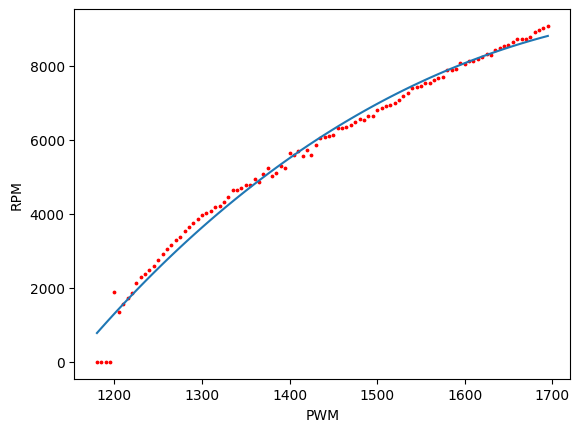

In [60]:
# Define the basic function for the rpm to thrust function
phi = np.power(pwm, [1, 0.5])
#print(phi)
assert phi.shape == (pwm.shape[0], 2)

# Train the model on the dataset
linreg.fit(phi, rpm)
w = linreg.coef_.reshape(-1,1)
print(w)

# Predict the values
predicted_rpm = linreg.predict(phi)
print(f"predicted_rpm: {predicted_thrust.shape}")

# Plot
fig, axes = plt.subplots()
axes.scatter(pwm, rpm, s=3, color='red')
axes.plot(pwm, predicted_rpm)
plt.xlabel('PWM')
plt.ylabel('RPM')

### Step response

In [94]:
# Load the data
filename = "Dataset_step copy.csv"
data = pd.read_csv(filename, sep=',')

# Convert time to seconds
data['T'] = data['T']/1000
data.describe()

,T,RPM
count,236.000000,236.000000
mean,2.632331,4802.107292
std,0.963074,1757.403138
min,0.000000,0.000000
25%,2.163750,4544.269000
50%,2.788000,5848.808000
75%,3.390500,5853.659000
max,3.993000,5858.803000


The test is executed as follows:
- get the motor going for 2 seconds with a pwm command of 1220
- send a pwm command of 1500 for another 2 seconds to simulate a step input

To analyze the step response we need to:
- separate the two parts of the signal
- compute the steady state RPM of the first part and subtract it
- compute the steady state RPM of the second part and divide by it

By doing so we get the second part to be a signal starting from 0 and converging to 1, which is easier to analyze

Steady state rpm first part: 1733.4770344827587
Steady state rpm second part: 5854.124381443299


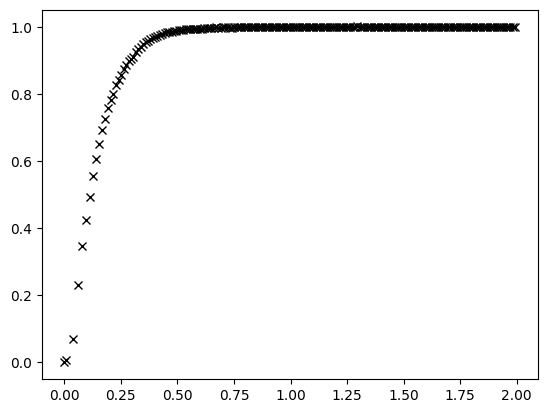

In [95]:
# Split the dataset
time_threshold = 2
time_max = 4
data_first_part = data[ data['T'] < time_threshold ]
data_second_part = data[ data['T'] > time_threshold ]

# Steady state RPM values
ss_time_interval = 1    # how much time to consider
ss_first_part = data_first_part[ data_first_part['T'] > (time_threshold - ss_time_interval) ]['RPM'].mean()
ss_second_part = data_second_part[ data_second_part['T'] > (time_max - ss_time_interval) ]['RPM'].mean()
print(f"Steady state rpm first part: {ss_first_part}")
print(f"Steady state rpm second part: {ss_second_part}")

# To numpy
t = data_second_part['T'].to_numpy().reshape(-1,1)
rpm = data_second_part['RPM'].to_numpy().reshape(-1,1)

# Subtract the first part ss rpm and divide by the second part ss rpm (scaled accordingly)
rpm = (rpm - ss_first_part) / (ss_second_part - ss_first_part)

# Subtract the time threshold so the signal starts from 0
t -= time_threshold

# Add a (0,0) point
t = np.insert(t,0,0,axis=0)
rpm = np.insert(rpm,0,0,axis=0)

# Plot to check everything is right
fig, ax = plt.subplots()
ax.plot(t, rpm, 'kx')


We can observe that the step response has the typical structure of a second order system, with a dominant pole and a faster pole. So the output evolution is modeled as
$$y(t) = y(\infty) + Ae^{\alpha t} + Be^{\beta t}$$

Assuming $\beta \gg \alpha$ (so the mode related to $\beta$ decays quickly and can be ignored initially), we write the approximation
$$ y(t) - y(\infty) \simeq  Ae^{\alpha t} $$

In order to estimate $A$ and $\alpha$ with linear regression, we need to linearize the equation with the logarithm:
$$ ln(y(t) - y(\infty)) \simeq  ln(Ae^{\alpha t}) = ln(A) + \alpha t $$
Note that if A is negative (so $y(\infty) > y(t)$), we need to invert the difference:
$$ ln(y(\infty) - y(t)) \simeq  ln(|A|e^{\alpha t}) = ln(|A|) + \alpha t $$

Studying the plot we obtain we can extract the optimal values for $\alpha$, which is the slope of the line, and $ln(A)$, which is the intercept

50
A: -1.4185875183028702	alpha: -9.560711061059983


/tmp/ipykernel_34999/555621975.py:8: RuntimeWarning: invalid value encountered in log
  log_y_diff = np.log( y_inf - y )


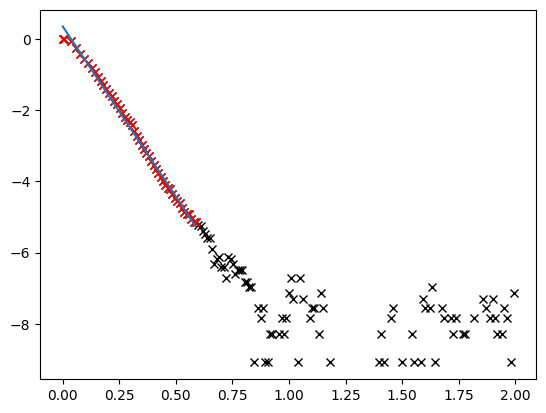

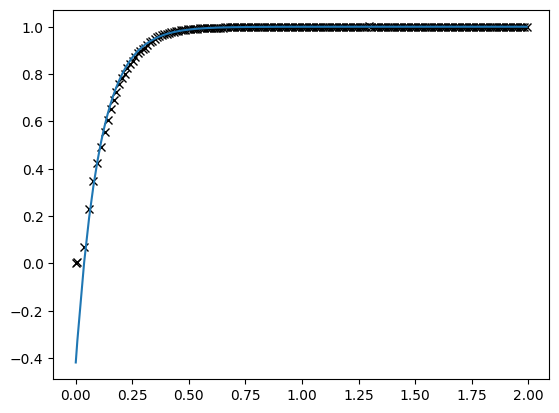

In [96]:
# We are in the case where A is negative

# Define y(t)=rpm and y(inf)=1
y = rpm
y_inf = 1       # Because we normalized the signal

# Compute the logarithm of the difference
log_y_diff = np.log( y_inf - y )

# Plot the log_diff
fig, ax = plt.subplots()
ax.plot(t, log_y_diff, 'kx')

# To reduce noise, consider only the first part of the signal
log_threshold = 0.6
indexes = np.where(t < log_threshold)       # Look where time is smaller than threshold
print(indexes[0][-1])                       # Index of the last element smaller than threshold
log_t = t[0:indexes[0][-1]]
log_y_diff = log_y_diff[0:indexes[0][-1]]
ax.plot(log_t, log_y_diff, 'rx')

# Linear regression
linreg.fit(log_t, log_y_diff)               # Fit the data
alpha = linreg.coef_[0][0]
A = -1 * np.exp(linreg.intercept_[0])          # We are in the case A < 0 
print(f"A: {A}\talpha: {alpha}")

# Check fit
ax.plot(log_t, linreg.predict(log_t))

# Check fit in the real response
fig,ax = plt.subplots()
ax.plot(t, y, 'kx')
ax.plot(t, y_inf + A*np.exp(alpha*t))

Now that we have the dominant pole, we can subtract its mode from the step response to obtain an approximation of the mode of the non-dominant pole
$$ y(t) - (y(\infty) + Ae^{\alpha t}) \simeq Be^{\beta t} $$

We apply the same procedure as before

6
B: 0.38930621545259875	beta: -39.55768968296225


(0.0, 0.5)

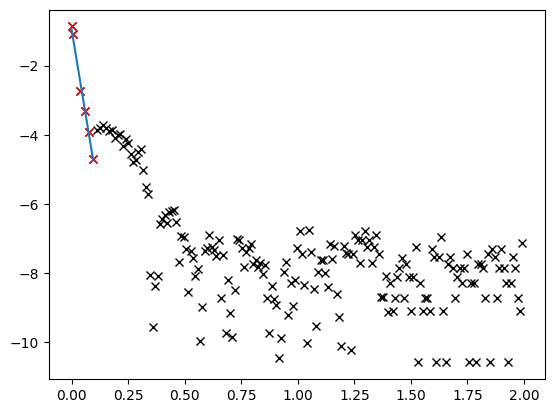

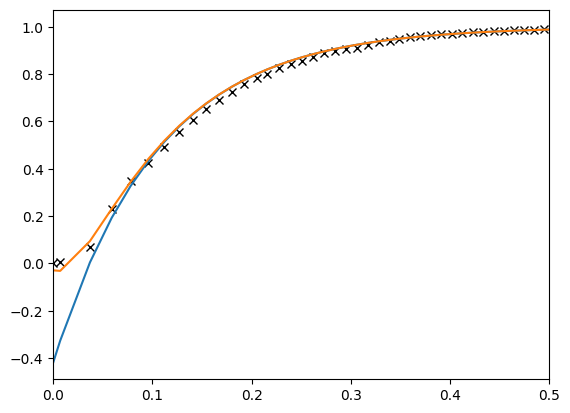

In [98]:
# Compute the logarithm of the difference
log_y_diff = np.log( abs( y - (y_inf + A*np.exp(alpha*t)) ) )

# Plot the log_diff
fig, ax = plt.subplots()
ax.plot(t, log_y_diff, 'kx')

# To reduce noise, consider only the first part of the signal
log_threshold = 0.12
indexes = np.where(t < log_threshold)       # Look where time is smaller than threshold
print(indexes[0][-1])                       # Index of the last element smaller than threshold
log_t = t[0:indexes[0][-1]]
log_y_diff = log_y_diff[0:indexes[0][-1]]
ax.plot(log_t, log_y_diff, 'rx')

# Linear regression
linreg.fit(log_t, log_y_diff)               # Fit the data
beta = linreg.coef_[0][0]
B = np.exp(linreg.intercept_[0])               # We are in the case B > 0 
print(f"B: {B}\tbeta: {beta}")

# Check fit
ax.plot(log_t, linreg.predict(log_t))

# Check fit in the real response
fig,ax = plt.subplots()
ax.plot(t, y, 'kx')
ax.plot(t, y_inf + A*np.exp(alpha*t))
ax.plot(t, y_inf + A*np.exp(alpha*t) + B*np.exp(beta*t))
ax.set_xlim([0,0.5])

#### Transfer function
The output equation (estimated) in the frequency domain is given by the laplace transform of the output response in the time domain
$$y(t) = y(\infty) + Ae^{\alpha t} + Be^{\beta t} \quad \Rightarrow \quad \hat{Y}(s) = \frac{1}{s} + \frac{A}{s-\alpha} + \frac{B}{s-\beta}$$

Common denominator:
$$ \hat{Y}(s) = \frac{(s-\alpha)(s-\beta) + As(s-\beta) + Bs(s-\alpha)}{s(s-\alpha)(s-\beta)} = \frac{(1 + A + B)s^2 + (-\alpha -\beta -A\beta -B\alpha)s - \alpha \beta}{s(s-\alpha)(s-\beta)}$$

To obtain the trasnfer function (rememebring that this is the step response) we divide by $\frac{1}{s}$:
$$ \hat{Y}(s) = \frac{1}{s} G(s) \quad \Rightarrow \quad G(s) = \frac{(1 + A + B)s^2 + (-\alpha -\beta -A\beta -B\alpha)s + \alpha \beta}{(s-\alpha)(s-\beta)}$$

Note that, in order to have a causal signal, the coefficient of $s^2$ in the numerator should be 0 (namely $A+B=-1$). This is not the case due to measurement errors and noise.

In [92]:
n2 = 1+A+B
n1 = -alpha -beta -A*beta - B*alpha
n0 = alpha*beta
numerator = np.poly1d([n2, n1, n0])
zeros = numerator.r

p1 = alpha
p2 = beta
poles = [p1,p2]

print(f"Zeros: {zeros}, Poles: {poles}")

Zeros: [-0.18260064  0.07073403], Poles: [-0.009560711061059976, -0.03955768968296234]
